In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

# [1] 빈칸을 작성하시오.
# Connect Directory
%cd /content/drive/MyDrive/outta/outta_3_project/


Mounted at /content/drive
/content/drive/MyDrive/outta/outta_3_project


In [ ]:
!pip install diffusers
!pip install -q -U google-generativeai
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 43.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl

In [ ]:
import os
import sys
import random
from io import BytesIO

import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import requests

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.models.vgg as vgg

from diffusers import StableDiffusionInpaintPipeline
from huggingface_hub import hf_hub_download

from codes.read_dataset import read_dataset
from codes.model import segmentation_model
from codes.train import train
from codes.segmentation import segementation
from codes.diffusion import *
from codes.llm import *
from codes.preprop import *

# Jupyter Notebook 내에서 matplotlib 출력 설정
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 32   # 절대 바꾸지 마세요.

model = segmentation_model().to(device)

# 하이퍼파라이터
epoch = 12
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# **1. Train**

In [ ]:
file_path = 'dataset/G2_train.h5'
data_len = 10000
img_list, gt_list = read_dataset(file_path, data_len)

In [ ]:
train(img_list, gt_list, model, epoch, learning_rate, optimizer, criterion, data_len)

# **2. Inference**

## **(1) Set the Model into Eval Mode**

In [ ]:
model = segmentation_model()

# 가중치를 CPU로 로드
model.load_state_dict(torch.load('', map_location=torch.device('cpu')))

# 모델을 평가 모드로 설정
model.eval()

## **(2) Load Image**

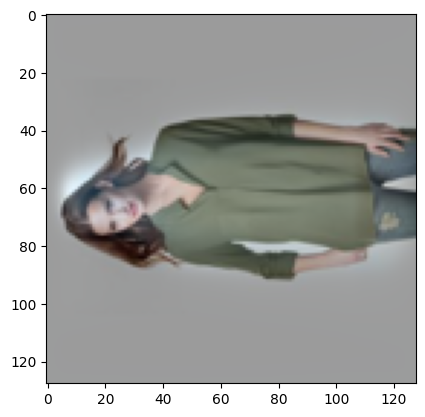

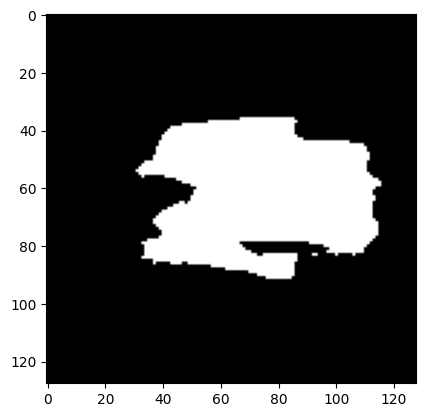

In [ ]:
image = np.load('./dataset/test_image3.npy')
plt.imshow(image)
plt.show()

# 결과 시각화
vis_output_model = segementation(image, model)
plt.imshow(vis_output_model)
plt.show()

## **(3) Inference**

### **1) LLM**

In [ ]:
# [2] 빈칸을 작성하시오.
# 적절한 프롬프트 튜닝을 통해서, 좋은 성능을 내보세요.
# [Example]
# prompt = "A Red short skirt, high quality, detailed, cute, with a lot of details, ."
# negative_prompt = "ugly"
prompt = "I want to change the top of the woman to a simple black shirt"
negative_prompt = "complex pattern, worst_quality, low_quality, bad anatomy, cropped hands, extra digit, fewer digit, text, error, jpeg artifacts"

text = LLM(f'{prompt}')
text

'{"top":["black","shirt"]}'

### **2) Segmentation & Inpainting**
- SAM for Segmentation

- Stable Diffusion for inpainting

In [ ]:
# [3] 빈칸을 작성하시오.
# 사전학습된 StableDiffusionInpaintPipeline 불러오고, GPU로 로드
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

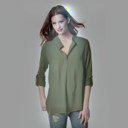

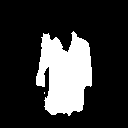

In [ ]:
# [4] 빈칸을 작성하시오.
# 이미지와 모델을 받아 Diffusion 모델에 적합한 형태로 전처리하는 함수 호출
image_source_pil, image_mask_pil = preprop_for_diffusion(image, vis_output_model=vis_output_model)

  0%|          | 0/50 [00:00<?, ?it/s]

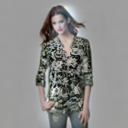

In [ ]:
# [5] 빈칸을 작성하시오.
# 이미지 생성 함수 호출: 주어진 이미지와 마스크를 기반으로 새로운 이미지를 생성
generated_image = generate_image(image_source_pil, image_mask_pil, text, negative_prompt, sd_pipe, seed, device)
generated_image

In [ ]:
# [6] 빈칸을 작성하시오.
# 생성된 이미지의 크기 조정
resized_image = generated_image.resize((512, 512))

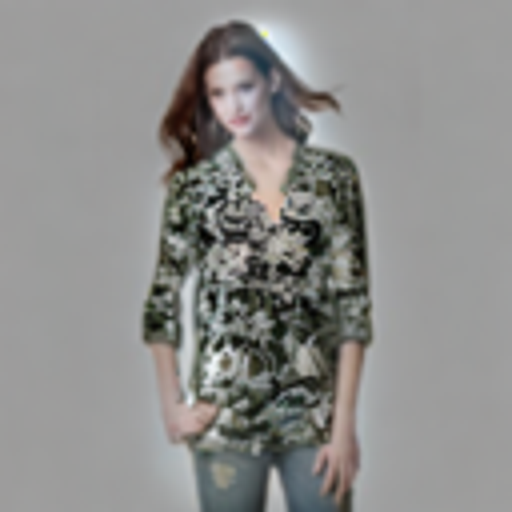

In [ ]:
resized_image